In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
def get_sigma(t, mem, df, K):
    mem_r = np.array(df['metric'][t - K - mem: t - K])
    r, sigma2 = np.mean(mem_r), np.var(mem_r)
    return r, sigma2

def get_port(w0, r, sigma2, s, gamma = 0.5):
    f = lambda w: r * w - gamma * sigma2 * (w ** 2) - s * abs(w - w0) 
    X = [-1.0, 2.0, w0, (r + s)/(2 * gamma * sigma2), (r - s)/(2 * gamma * sigma2)]
    X = [x for x in X if -1.0 <= x and x <= 2.0]
    Y = [f(x) for x in X]
    I = np.argmax(Y)
    w1 = X[I]
    return w1
    
def simulate(df, K, step, mem, s, gamma, shift = 0):
    T = len(df)
    t = mem + K + shift
    money = 1
    coins = 0
    price = 0
    counter = 1000
    record = []

    while(t < T and money + price * coins > 0):
        r_stat, sigma2 = get_sigma(t, mem, df, K)
        r_pred = df['preds'][t]
        price = df['midpoint'][t]
    
        money =  money + price * coins
        wb = price * coins / money
        coins = 0
        
        w0 = get_port(w0 = wb, r = r_pred, sigma2 = sigma2, 
                      s = s, gamma = gamma)
        
        record.append([t, money, price, w0])
            
        #if(counter * step > 10000):
        #    print(np.ceil(t/10000) - 1,'/',np.ceil(T/10000),' money =', money, ' w0 =', w0)
        #    counter = 0
        #counter += 1
        
        coins = w0 * money / price
        money = (1 - w0 - s * abs(w0 - wb)) * money
        t += step

    record = np.array(record).T    
    money += price * coins
    print('Final: money =', money)
    return record
    

In [4]:
times = [5, 15, 60, 180, 720, 1440]
K = 60
mem = 60 * 24
step = K #опытным путем, K = step работает лучше всего
s = 0.001
gamma = 5.0
df = pl.read_parquet("btc-augfeb-ema-eth-feat-select-v3/" + str(K) + ".pq")

record = [simulate(df, K, step, mem, s, gamma, shift = shift)[0:3] for shift in range(step)]

Final: money = 1.7797617486416604
Final: money = 1.8871251182762043
Final: money = 1.8585014503582542
Final: money = 1.656280536785612
Final: money = 1.618853345642558
Final: money = 1.6309847705565657
Final: money = 1.7491948473209076
Final: money = 1.7616725546172756
Final: money = 1.7235264011159892
Final: money = 1.8022994193811412
Final: money = 1.6651104999026372
Final: money = 1.8466264177235665
Final: money = 1.994260578746852
Final: money = 2.156778707048827
Final: money = 1.9829489525533661
Final: money = 2.2145102053776498
Final: money = 2.167913828586024
Final: money = 2.072797272176921
Final: money = 2.010088238742908
Final: money = 1.985981625289504
Final: money = 1.6497097534594414
Final: money = 1.7148801804605913
Final: money = 1.59636455280998
Final: money = 1.5358706252559504
Final: money = 1.6081458839583318
Final: money = 1.714630489324139
Final: money = 1.68749067046138
Final: money = 1.5157742653574713
Final: money = 1.4849451099883186
Final: money = 1.3700885921

1.7108951632958063 3.333733406407166


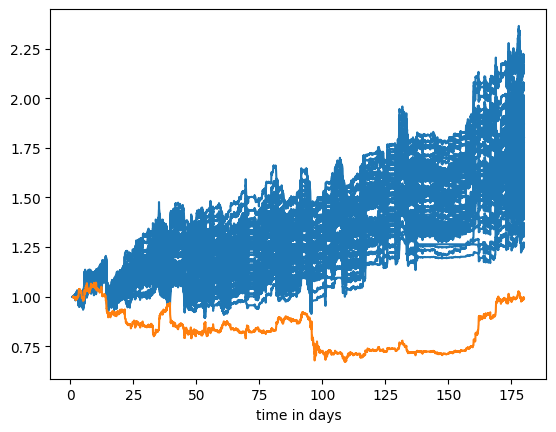

In [6]:
color = 'tab:blue'
plt.xlabel('time in days')
for dataset in record:
    x = dataset[0]
    y = dataset[1]
    plt.plot(x / 60 / 24, y, color = color)

color = 'tab:orange'
plt.plot(record[0][0] / 60 / 24, record[0][2] / record[0][2][0], color = color, label = 'coin price')
a = [dataset[1][-1] for dataset in record]
print(np.mean(a), (np.mean(a) - 1)/np.sqrt(np.var(a)))

In [ ]:
def get_dot(gamma):
    times = [5, 15, 60, 180, 720, 1440]
    K = 60
    mem = 60 * 24
    step = K #опытным путем, K = step работает лучше всего
    s = 0.001
    df = pl.read_parquet("btc-augfeb-ema-eth-feat-select-v3/" + str(K) + ".pq")
    record = [simulate(df, K, step, mem, s, gamma, shift = shift)[0:3] for shift in range(step)]
    a = [dataset[1][-1] for dataset in record]
    r, sigma = np.mean(a) - 1, np.sqrt(np.var(a))
    return r, sigma, gamma

In [ ]:
dots = []
for _ in range(100):
    gamma = 5 * np.random.random()
    r, sigma, gamma = get_dot(gamma)
    print('------------------','r =', r, 'sigma =', sigma, 'gamma =', gamma, '------------------')
    dots.append([r, sigma, gamma])
dots = np.array(dots).T
d = ((dots.T)[np.lexsort(dots)]).T
plt.plot(d[1], d[0])